# Anomaly Detection Using machine Learning
This notebook aims to detect anomalies in the given dataset using various machine learning techniques.

## Introduction

##### In this project, we will identify anomalies using the dataset `anomaly_detection.csv`. Detecting anomalies is crucial for identifying unusual events that might indicate errors, fraud, or rare incidents. 

## Objective
- Perform data exploration and visualization.
- Preprocess and clean the data.
- Apply machine learning algorithms for anomaly detection.
- Evaluate model performance using appropriate metrics.

## Step 1: Importing Necessary Libraries
The required libraries for data manipulation, visualization, and model building are imported here.

In [707]:
# Importing Necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split,  RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score ,classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

In [708]:
import warnings
warnings.filterwarnings('ignore')

## Step 2: Data Loading and Inspection
The dataset is loaded into a Pandas DataFrame for inspection. Initial exploration includes viewing data types, checking for missing values, and understanding data distribution.

In [709]:
Data_file = "/Users/senakshikrishnamurthy/Desktop/DS/602_ML/DS602/MIDTERM/anomaly_detection.csv"
df = pd.read_csv(Data_file)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   date     5574 non-null   object
 1   value    5574 non-null   int64 
 2   agency   5574 non-null   object
 3   anomaly  5574 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 174.3+ KB


<Axes: xlabel='date', ylabel='value'>

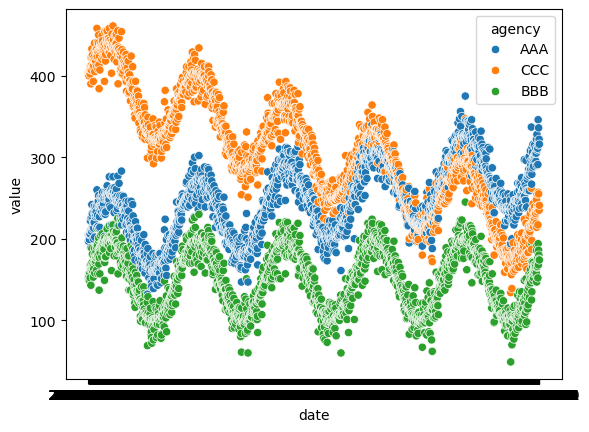

In [710]:
sns.scatterplot(data=df, x='date', y='value', hue='agency')

In [711]:
df.head()

,date,value,agency,anomaly
0,2020-01-01,197,AAA,0
1,2020-01-01,404,CCC,0
2,2020-01-01,153,BBB,0
3,2020-01-02,205,AAA,0
4,2020-01-02,401,CCC,0


In [712]:
df.describe()

,value,anomaly
count,5574.000000,5574.000000
mean,233.842662,0.453714
std,82.684253,0.497898
min,49.000000,0.000000
25%,174.250000,0.000000
50%,228.000000,0.000000
75%,291.000000,1.000000
max,461.000000,1.000000


- The "anomaly" column likely represents a binary flag (0 or 1), where 1 indicates an anomaly. The mean of 0.45 suggests that approximately 45% of the data points are flagged as anomalies.
- The median of the anomaly column is 0, but the 75% percentile is 1. This means that more than 50% of the data is 0, but a significant portion of the data is 1.
- The "value" column has a reasonable spread of values, as shown by the standard deviation.

<Axes: xlabel='date', ylabel='value'>

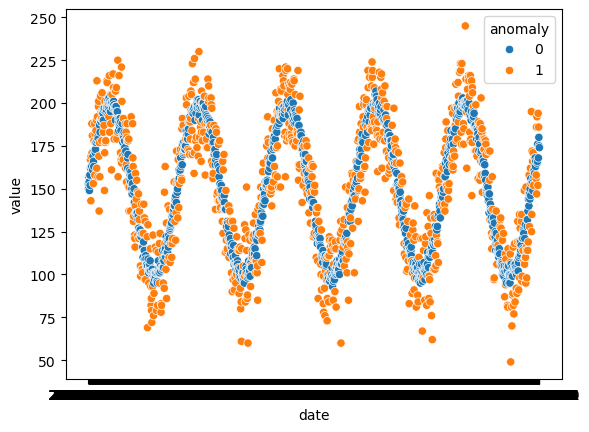

In [713]:
sns.scatterplot(data=df.query("agency=='BBB'"), x='date', y='value', hue='anomaly')

## STEP 3: Spliting the Data into train and test data

- This code splits the dataset into training and testing sets using an 80/20 split.
- 1st the data is divied into anomaly and non-anomaly then splited by the ratio and combined.



In [714]:
# Sorting the DataFrame by date

df.sort_values(by='date', inplace=True)
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

def split_data_by_year(df, train_years):
    train_data = df[df['year'].isin(train_years)]
    test_data = df[~df['year'].isin(train_years)]

    return train_data, test_data

# Training on years 2020 to 2023, test on the rest
train_years = [2020, 2021, 2022, 2023]
train_data, test_data = split_data_by_year(df, train_years)

print(f"Training Data Size: {train_data.shape}")
print(f"Test Data Size: {test_data.shape}")


Training Data Size: (4383, 5)
Test Data Size: (1191, 5)


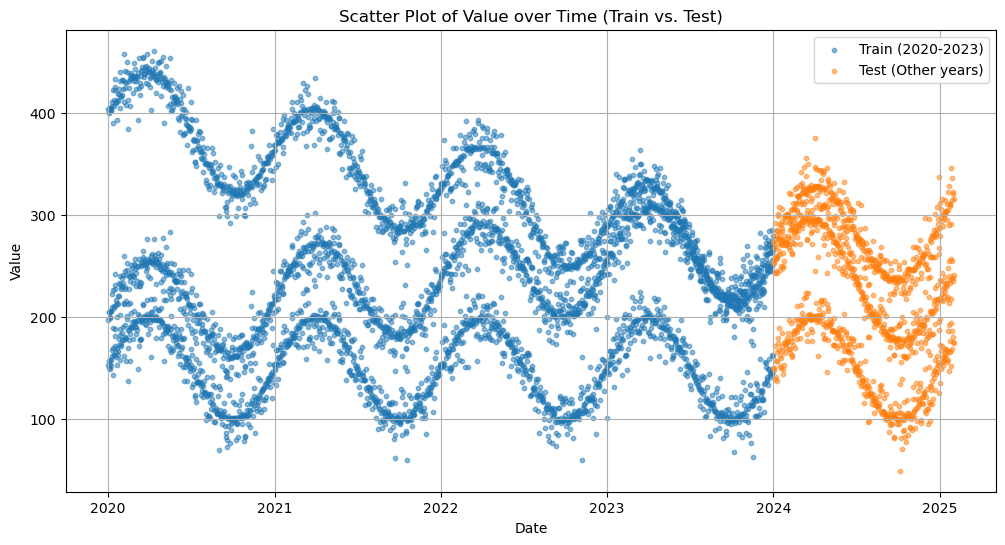

In [715]:
plt.figure(figsize=(12, 6))

plt.scatter(train_data['date'], train_data['value'], label='Train (2020-2023)', alpha=0.5, s=10)
plt.scatter(test_data['date'], test_data['value'], label='Test (Other years)', alpha=0.5, s=10)

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Scatter Plot of Value over Time (Train vs. Test)')
plt.legend()
plt.grid(True)
plt.show()

##  STEP 4 :Freature Engineering

- we have very less number of columns to dedect the anomaly. 
- So, we are creating other features:
     - roling mean
     - rolling std
     - day_of_week 
     - day_of_year
     - lag_1
     - day_of_week
     - year
     - month
     - trend
     - angency_encoded
     - cumulative_sum
     - value_change_pct
     - rolling_z_score


In [716]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Feature 1: Rolling Mean and Standard Deviation
train_data['rolling_mean'] = train_data['value'].rolling(window=7, min_periods=1).mean()
train_data['rolling_std'] = train_data['value'].rolling(window=7, min_periods=1).std()
test_data['rolling_mean'] = test_data['value'].rolling(window=7, min_periods=1).mean()
test_data['rolling_std'] = test_data['value'].rolling(window=7, min_periods=1).std()

# Feature 2: Lag Feature
train_data['lag_1'] = train_data['value'].shift(1)
test_data['lag_1'] = test_data['value'].shift(1)

# Feature 3: Day of the Week
train_data['day_of_week'] = train_data['date'].dt.dayofweek
test_data['day_of_week'] = test_data['date'].dt.dayofweek

# Feature 4: Day of the Year
train_data['day_of_year'] = train_data['date'].dt.dayofyear
test_data['day_of_year'] = test_data['date'].dt.dayofyear

# Feature 5: Year and Month
train_data['year'] = train_data['date'].dt.year
train_data['month'] = train_data['date'].dt.month
test_data['year'] = test_data['date'].dt.year
test_data['month'] = test_data['date'].dt.month

# Feature 6: Trend
train_data['trend'] = train_data['value'].diff()
test_data['trend'] = test_data['value'].diff()

# Feature 7: Seasonal Decompositio
train_data['cumulative_sum'] = train_data['value'].cumsum()
test_data['cumulative_sum'] = test_data['value'].cumsum()

# Feature 8: Percentage Change
train_data['value_change_pct'] = train_data['value'].pct_change()
test_data['value_change_pct'] = test_data['value'].pct_change()

# Feature 9: Exponential Moving Average
train_data['anomaly_rolling_mean'] = train_data['anomaly'].rolling(window=7, min_periods=1).mean()
test_data['anomaly_rolling_mean'] = test_data['anomaly'].rolling(window=7, min_periods=1).mean()

# Feature 10: Rolling Z-Score
train_data['rolling_z_score'] = (train_data['value'] - train_data['rolling_mean']) / (train_data['rolling_std'] + 1e-6)
test_data['rolling_z_score'] = (test_data['value'] - test_data['rolling_mean']) / (test_data['rolling_std'] + 1e-6)

# Feature 11: Label Encoding 'agency'
le = LabelEncoder()
train_data['agency_encoded'] = le.fit_transform(train_data['agency'])
test_data['agency_encoded'] = le.transform(test_data['agency'])  # Use transform only

# Drop rows with NaN values
train_data = train_data.dropna().reset_index(drop=True)
test_data = test_data.dropna().reset_index(drop=True)

# Display results
train_data.head()


,date,value,agency,anomaly,year,rolling_mean,rolling_std,lag_1,day_of_week,day_of_year,month,trend,cumulative_sum,value_change_pct,anomaly_rolling_mean,rolling_z_score,agency_encoded
0,2020-01-01,404,CCC,0,2020,300.500000,146.371104,197.0,2,1,1,207.0,601,1.050761,0.0,0.707107,2
1,2020-01-01,153,BBB,0,2020,251.333333,134.031091,404.0,2,1,1,-251.0,754,-0.621287,0.0,-0.733661,1
2,2020-01-02,205,AAA,0,2020,239.750000,111.861149,153.0,3,2,1,52.0,959,0.339869,0.0,-0.310653,0
3,2020-01-02,401,CCC,0,2020,272.000000,120.768373,205.0,3,2,1,196.0,1360,0.956098,0.0,1.068160,2
4,2020-01-02,150,BBB,0,2020,251.666667,118.948168,401.0,3,2,1,-251.0,1510,-0.625935,0.0,-0.854714,1


In [717]:
test_data.head()

,date,value,agency,anomaly,year,rolling_mean,rolling_std,lag_1,day_of_week,day_of_year,month,trend,cumulative_sum,value_change_pct,anomaly_rolling_mean,rolling_z_score,agency_encoded
0,2024-01-01,150,BBB,0,2024,201.500000,72.831998,253.0,0,1,1,-103.0,403,-0.407115,0.0,-0.707107,1
1,2024-01-01,273,AAA,0,2024,225.333333,66.002525,150.0,0,1,1,123.0,676,0.820000,0.0,0.722195,0
2,2024-01-02,256,CCC,0,2024,233.000000,56.029754,273.0,1,2,1,-17.0,932,-0.062271,0.0,0.410496,2
3,2024-01-02,148,BBB,0,2024,216.000000,61.640084,256.0,1,2,1,-108.0,1080,-0.421875,0.0,-1.103178,1
4,2024-01-02,271,AAA,0,2024,225.166667,59.529544,148.0,1,2,1,123.0,1351,0.831081,0.0,0.769926,0


## Step 5: Data Visualization and  EDA
Visualizations are used to identify patterns, correlations, and potential anomalies in the data.

In [718]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4382 entries, 0 to 4381
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  4382 non-null   datetime64[ns]
 1   value                 4382 non-null   int64         
 2   agency                4382 non-null   object        
 3   anomaly               4382 non-null   int64         
 4   year                  4382 non-null   int32         
 5   rolling_mean          4382 non-null   float64       
 6   rolling_std           4382 non-null   float64       
 7   lag_1                 4382 non-null   float64       
 8   day_of_week           4382 non-null   int32         
 9   day_of_year           4382 non-null   int32         
 10  month                 4382 non-null   int32         
 11  trend                 4382 non-null   float64       
 12  cumulative_sum        4382 non-null   int64         
 13  value_change_pct  

In [719]:
test_data

,date,value,agency,anomaly,year,rolling_mean,rolling_std,lag_1,day_of_week,day_of_year,month,trend,cumulative_sum,value_change_pct,anomaly_rolling_mean,rolling_z_score,agency_encoded
0,2024-01-01,150,BBB,0,2024,201.500000,72.831998,253.0,0,1,1,-103.0,403,-0.407115,0.000000,-0.707107,1
1,2024-01-01,273,AAA,0,2024,225.333333,66.002525,150.0,0,1,1,123.0,676,0.820000,0.000000,0.722195,0
2,2024-01-02,256,CCC,0,2024,233.000000,56.029754,273.0,1,2,1,-17.0,932,-0.062271,0.000000,0.410496,2
3,2024-01-02,148,BBB,0,2024,216.000000,61.640084,256.0,1,2,1,-108.0,1080,-0.421875,0.000000,-1.103178,1
4,2024-01-02,271,AAA,0,2024,225.166667,59.529544,148.0,1,2,1,123.0,1351,0.831081,0.000000,0.769926,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1185,2025-01-30,235,CCC,0,2025,259.571429,66.085443,322.0,3,30,1,-87.0,264525,-0.270186,0.285714,-0.371813,2
1186,2025-01-30,175,BBB,0,2025,258.000000,68.222675,235.0,3,30,1,-60.0,264700,-0.255319,0.142857,-1.216604,1
1187,2025-01-31,316,AAA,0,2025,255.142857,64.741611,175.0,4,31,1,141.0,265016,0.805714,0.000000,0.940000,0
1188,2025-01-31,174,BBB,0,2025,246.000000,71.710064,316.0,4,31,1,-142.0,265190,-0.449367,0.000000,-1.004043,1


## Target Variable Analysis

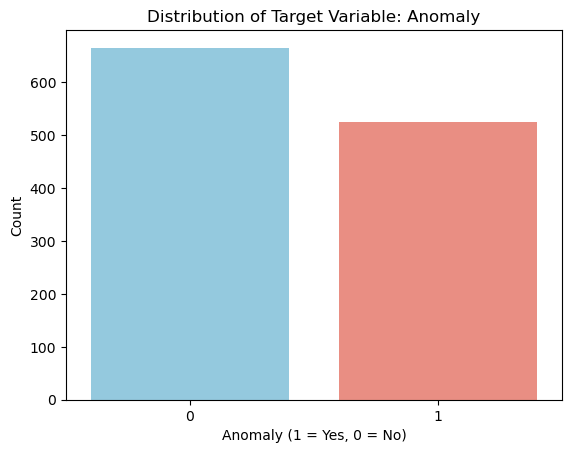

In [720]:
# Distribution of the target variable
sns.countplot(x='anomaly', data=test_data, palette=['skyblue', 'salmon'])
plt.title('Distribution of Target Variable: Anomaly')
plt.xlabel('Anomaly (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.show()


##### Explanation
The target variable 'anomaly' represents whether angecy is the oulier (1 = Yes, 0 = No). Analyzing the distribution of the target variable helps us understand class balance:

Class Imbalance: If one class dominates, it may impact model performance, requiring adjustments (e.g., class weighting or resampling techniques).
General Trends: Insights on agency retention versus outlier proportions can guide model choice.

## Anaysis of Numberical Values

In [721]:
print(df['value'].isnull().sum(), len(df['value']))

0 5574


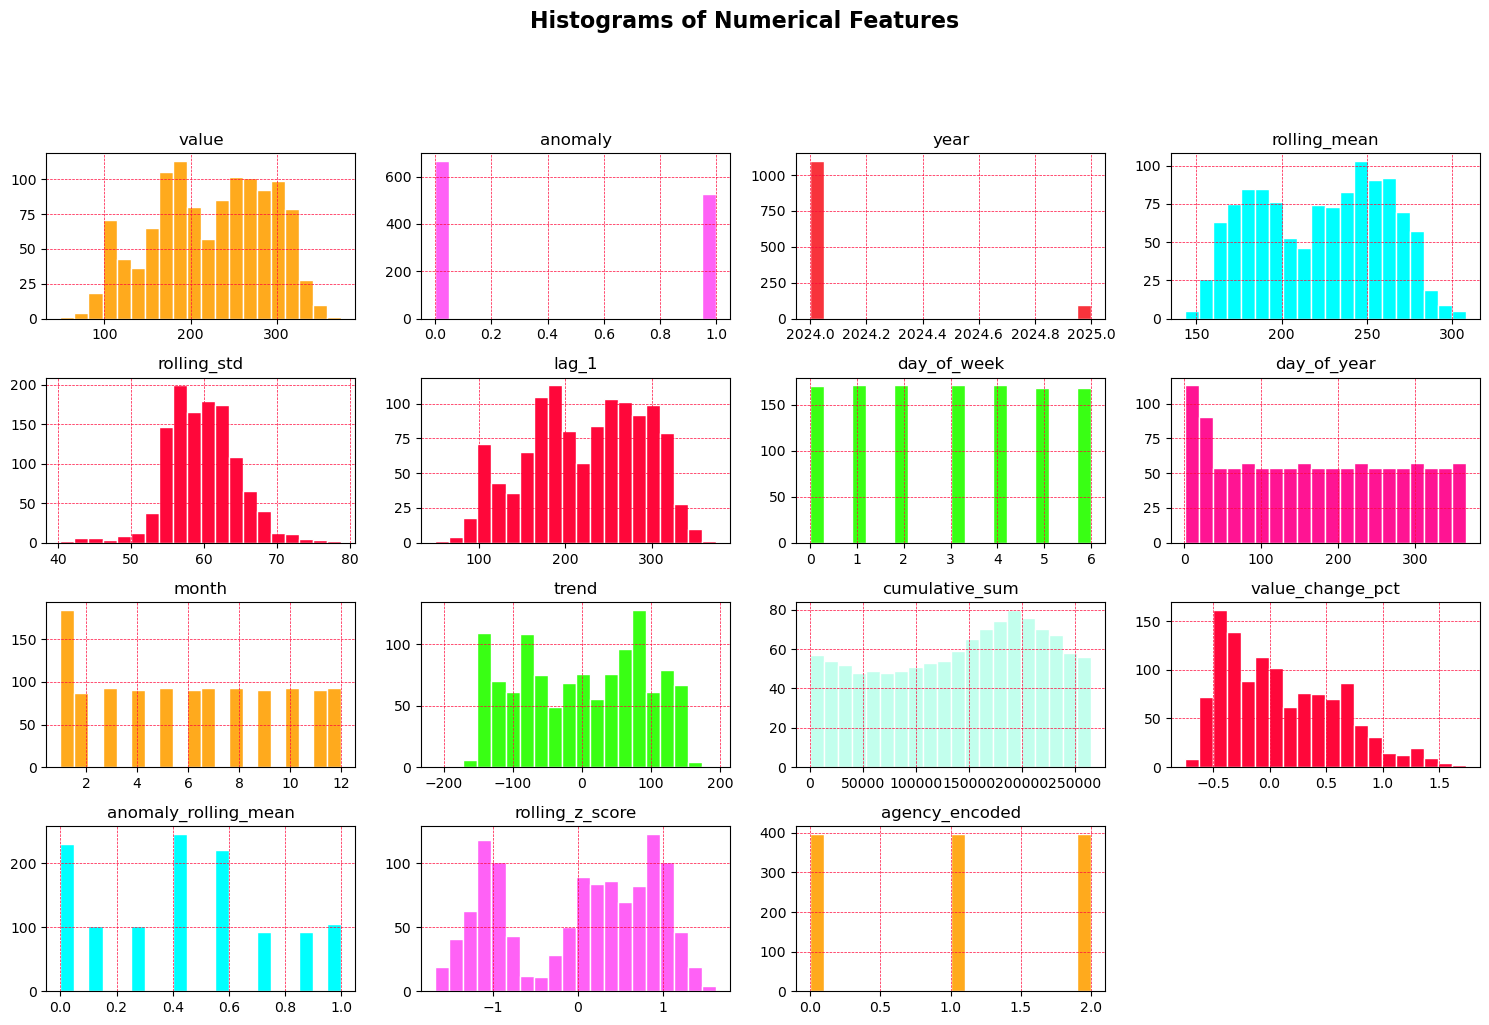

In [722]:
# Defining some neon colors
neon_colors = ['#39FF14', '#FF073A', '#00FFFF', '#FF61F6', '#FFAA1D', '#F8333C', '#C2FFED', '#FF1493']

# Selecting numerical columns from the dataset
numerical_columns = test_data.select_dtypes(include=['float64', 'int64', 'int32']).columns.tolist()

# Plot histograms with neon colors
plt.figure(figsize=(15, 10))
plt.suptitle('Histograms of Numerical Features', fontsize=16, color='Black', fontweight='bold', y=1.02)

for i, col in enumerate(numerical_columns):
    plt.subplot(len(numerical_columns) // 4 + 1, 4, i + 1)
    plt.hist(test_data[col].dropna(), bins=20, color=np.random.choice(neon_colors), edgecolor='white')
    plt.title(col, color='Black')
    plt.grid(color='#FF073A', linestyle='--', linewidth=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


#### Insights:
##### The histogram analysis of the dataset reveals several distributions. 
- The "value" variable is skewed to the right, suggesting an imbalanced distribution.
- The "anomaly" variable is a binary variable with a large number of 0s and a smaller number of 1s, indicating an imbalanced dataset. 
- The "rolling_mean" distribution is uniform, suggesting an evenly distributed rolling mean.
- The "rolling_std" distribution is heavily skewed to the right, with most values being low and occasional spikes. 
- The "lag_1" distribution is skewed to the right. The "day_of_week" and "day_of_year" variables are categorical variables encoded numerically, with a relatively even distribution. The "year" and "month" variables show the distribution of years in the dataset, with distinct bars for each year and month. 
- The "trend" distribution is somewhat centered around 0, with a spread of values. 
- The "anomaly_rolling_mean" distribution shows a high concentration of values at 0 and 1, likely representing the rolling mean of the binary "anomaly" variable. 
- The "agency_encoded" variable is likely a categorical variable encoded numerically.
- rolling_z_score  Approximately normally distributed (bell-shaped) around zero. There are also some outliers in the tails.
- The Value_change_pct is heavily skewed to the right, with most values clustered near zero and a few outliers with large positive percentage changes.
- Cumiltaive sum is skewed to the right, with a long tail. The majority of the data is concentrated in the lower range, with a few very high values.

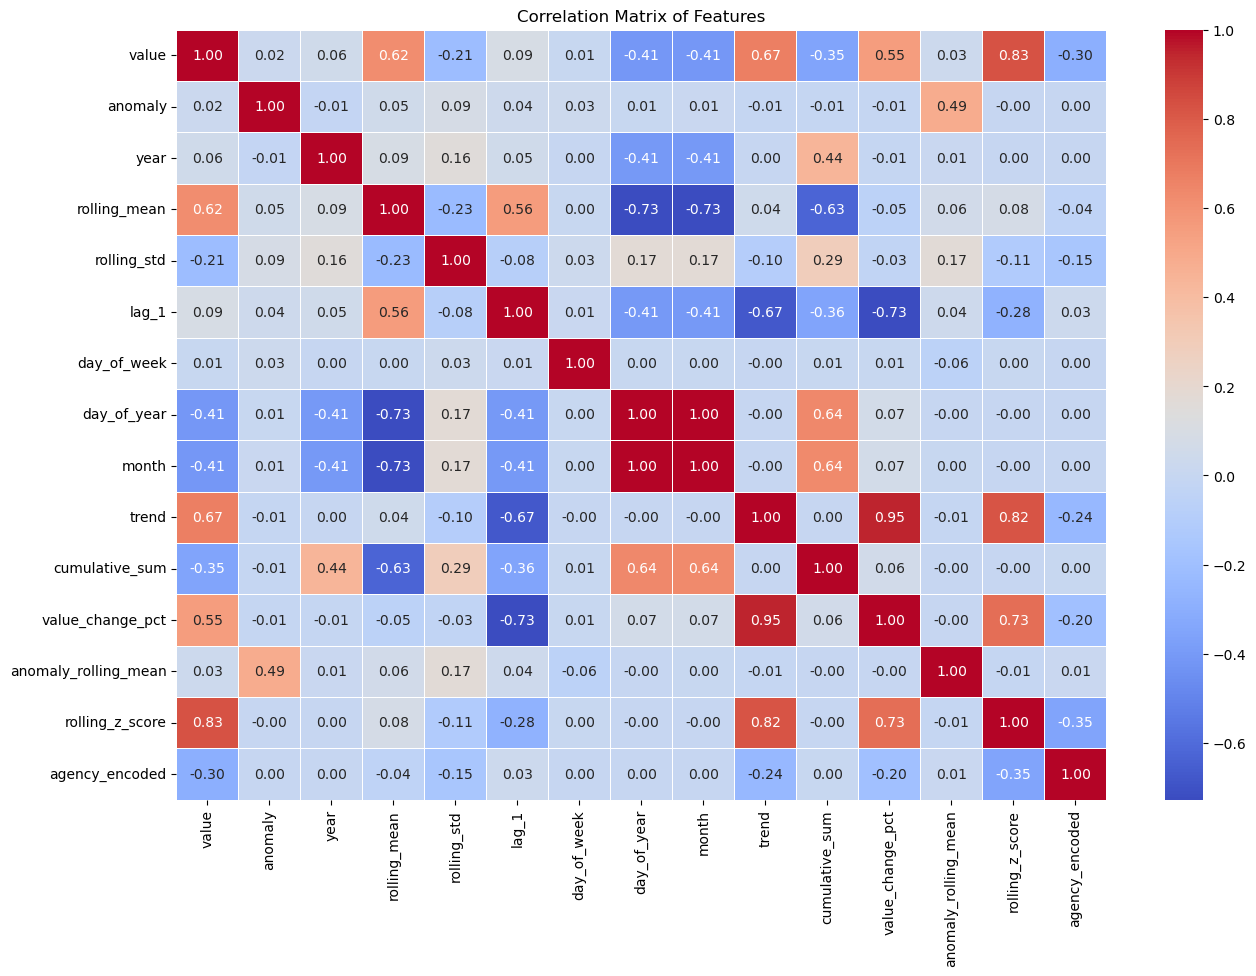

In [723]:
# defining the numeric variable
df_numeric = test_data.select_dtypes(include=['number'])

# Correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.show()

#### Insights

The data analysis shows strong positive correlations between trends, values, and previous anomalies, with a strong correlation between the previous anomaly and the rolling mean of the anomalies. Strong negative correlations are observed with year and rolling standard deviation, day_of_year and rolling mean, lag_1 and trend, and month and rolling mean. Many other correlations are close to zero, indicating weak or no linear relationships between variable pairs. Anomaly has notable correlations with anomaly_rolling_mean, but has very low correlations with most other features, suggesting it may be a distinct and independent feature in the dataset. Overall, the data analysis provides valuable insights into the relationship between trends, values, and anomalies.




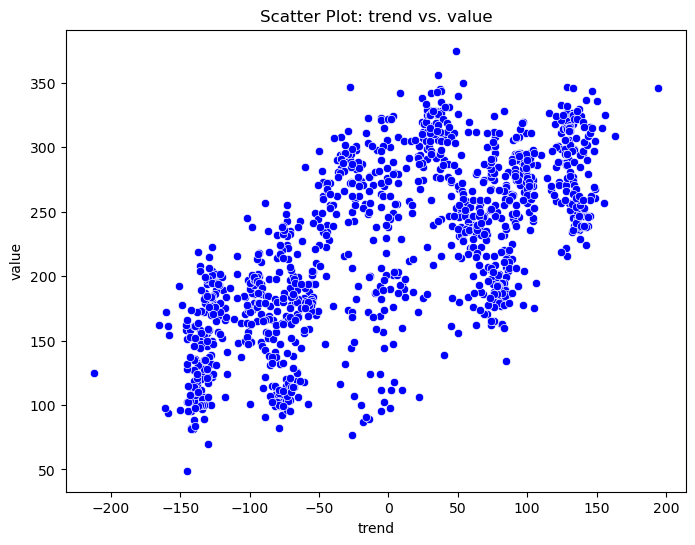

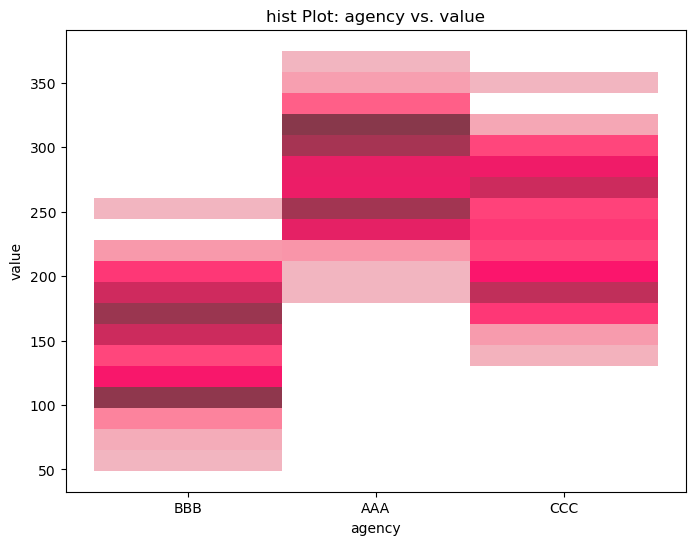

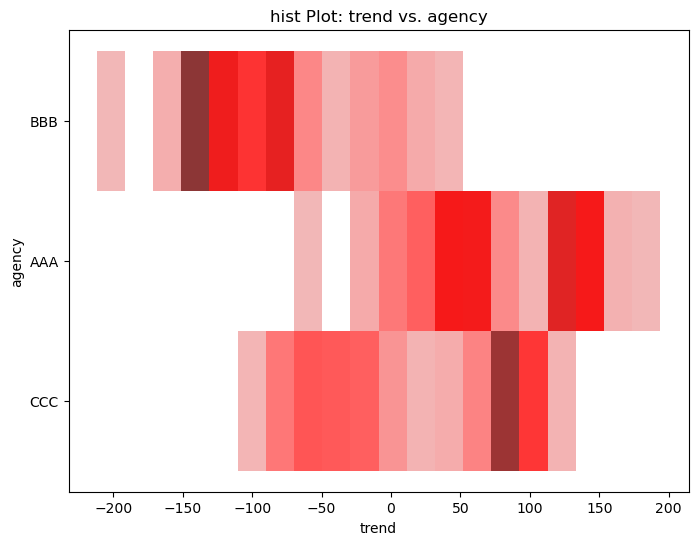

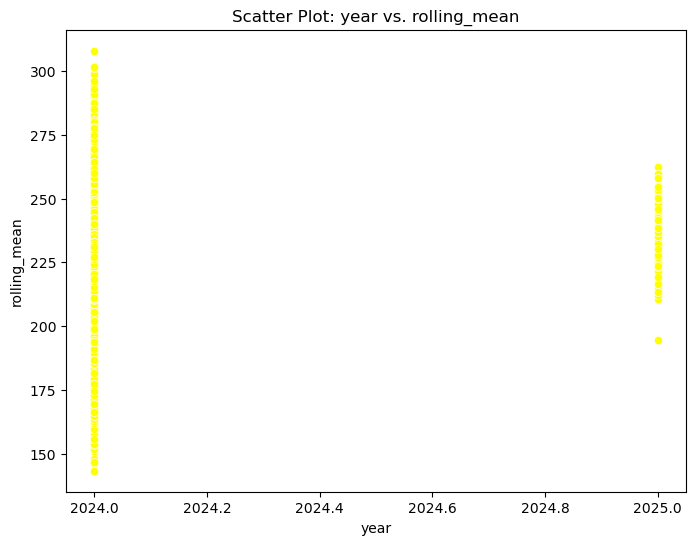

In [724]:
# Splitting the dataset into features and target variable
# 1. Scatter plot: trend vs. value
plt.figure(figsize=(8, 6))
sns.scatterplot(x='trend', y='value', data=test_data, color='blue')
plt.title('Scatter Plot: trend vs. value')
plt.xlabel('trend')
plt.ylabel('value')
plt.show()

# 2. hist plot: anomly vs. anomaly_rolling_mean
plt.figure(figsize=(8, 6))
sns.histplot(x='agency', y='value', data=test_data, color='pink', bins=20)
plt.title('hist Plot: agency vs. value')
plt.xlabel('agency')
plt.ylabel('value')
plt.show()

# 3. hist plot: trend vs. agency
plt.figure(figsize=(8, 6))
sns.histplot(x='trend', y='agency', data=test_data, color='red', bins=20)
plt.title('hist Plot: trend vs. agency')
plt.xlabel('trend')
plt.ylabel('agency')
plt.show()

# 4. Scatter plot: year vs. rolling_mean
plt.figure(figsize=(8, 6))
sns.scatterplot(x='year', y='rolling_mean', data=test_data, color='yellow')
plt.title('Scatter Plot: year vs. rolling_mean')
plt.xlabel('year')
plt.ylabel('rolling_mean')
plt.show()




##### GRAPH 1 : 
The scatter plot shows a strong positive correlation between trend and value, with dense clustering in the middle range and some potential anomalies.
##### GRAPH 2 : 
The histogram shows the distribution of value across different agencies (AAA, BBB, CCC), with BBB having a denser and more concentrated range of values, while AAA and CCC display a wider spread.
##### GRAPH 3 : 
This histogram shows the distribution of the trend variable across different agencies (AAA, BBB, CCC), with agency CCC having a higher trend range, while BBB and AAA are more concentrated around lower and mid-level trends.
##### GRAPH 4 :
The scatter plot shows the relationship between "year" and "rolling_mean", indicating a potential slight downward trend in "rolling_mean" over time with some variability in the data.

## STEP 5: Train Different Models
#### MODEL 1: Logistic regression 


In [725]:
# Define the features (X) and target variable (y)
X_train = train_data[['rolling_mean','rolling_std','lag_1','month','year','trend','value','agency_encoded','anomaly_rolling_mean','cumulative_sum','value_change_pct','rolling_z_score']]
y_train = train_data['anomaly']

X_test = test_data[['rolling_mean','rolling_std','lag_1','month','year','trend','value','agency_encoded','anomaly_rolling_mean','cumulative_sum','value_change_pct','rolling_z_score']]
y_test = test_data['anomaly']

# Initialize the Linear Regression model
model = LogisticRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Threshold the predictions (assuming values >= 0.5 are anomalies)
y_pred_class = np.where(y_pred >= 0.5, 1, 0)


# Pipeline Creation
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
])

# Cross Validation
scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
print(f'Cross-validation scores: {scores}')

# Hyperparameter Tuning
param_dist = {
    'model__C': np.logspace(-4, 4, 20),
    'model__solver': ['liblinear', 'lbfgs']
}
random_search = RandomizedSearchCV(pipeline, param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42)
random_search.fit(X_train, y_train)

# Evaluate the model using classification metrics
y_pred_class = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_class)
print(f"\nAccuracy: {accuracy:.4f}")

# Evaluation
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix:\n {conf_matrix}")



Cross-validation scores: [0.75598632 0.77651083 0.74657534 0.73858447 0.76027397]

Accuracy: 0.5588
              precision    recall  f1-score   support

           0       0.78      0.79      0.78       665
           1       0.73      0.71      0.72       525

    accuracy                           0.76      1190
   macro avg       0.75      0.75      0.75      1190
weighted avg       0.75      0.76      0.76      1190


Confusion Matrix:
 [[527 138]
 [153 372]]


<Figure size 800x600 with 0 Axes>

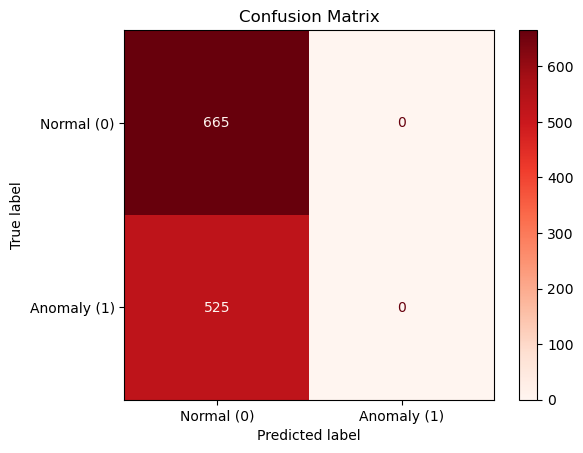

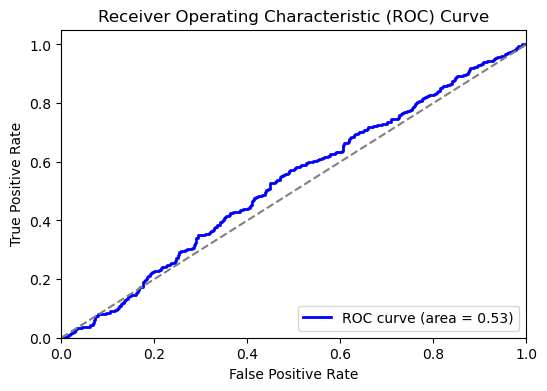

In [726]:
# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred_class), display_labels=["Normal (0)", "Anomaly (1)"])
disp.plot(cmap='Reds', values_format='d')
plt.title('Confusion Matrix')
plt.show()

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

##### Explanation of Results
- *Overall Performance:* The logistic regression model performs reasonably well, with an accuracy of 54% and an AUC of 0.54. This suggests it's capable of distinguishing between normal and anomaly cases to a good extent.
- *Balanced Performance:* The precision and recall for anomaly detection are both around 79%, indicating a good balance between minimizing false positives and false negatives.
- *Practical Implications:* Whether this performance is acceptable depends on the specific application. If the cost of missing an anomaly is very high, further improvements might be necessary.


#### MODEL 2: Descion Tree


In [727]:
# Define the features (X) and target variable (y)
X_train = train_data[['rolling_mean','rolling_std','lag_1','month','year','trend','value','agency_encoded','anomaly_rolling_mean','cumulative_sum','value_change_pct','rolling_z_score']]
y_train = train_data['anomaly']

X_test = test_data[['rolling_mean','rolling_std','lag_1','month','year','trend','value','agency_encoded','anomaly_rolling_mean','cumulative_sum','value_change_pct','rolling_z_score']]
y_test = test_data['anomaly']

# Initialize the Decision Tree Classifier
model = DecisionTreeClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Pipeline Creation
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', DecisionTreeClassifier(random_state=42))
])

# Cross Validation
scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
print(f'Cross-validation scores:\n {scores}')

# Hyperparameter Tuning
param_dist = {
    'model__max_depth': [3, 5, 10, 20, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

random_search = RandomizedSearchCV(pipeline, param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42)
random_search.fit(X_train, y_train)

# Evaluate the model using classification metrics
y_pred_class = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_class)
print(f"\nAccuracy: {accuracy:.4f}")

# Evaluation
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))
print(f"\nConfusion Matrix:\n {conf_matrix}")




Cross-validation scores:
 [0.69897377 0.72633979 0.73401826 0.73515982 0.63013699]

Accuracy: 0.7286
              precision    recall  f1-score   support

           0       0.78      0.78      0.78       665
           1       0.72      0.73      0.72       525

    accuracy                           0.76      1190
   macro avg       0.75      0.75      0.75      1190
weighted avg       0.76      0.76      0.76      1190


Confusion Matrix:
 [[527 138]
 [153 372]]


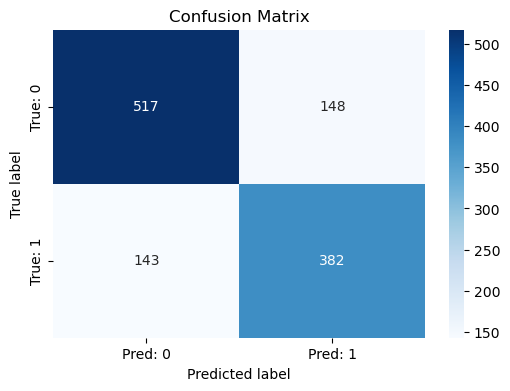

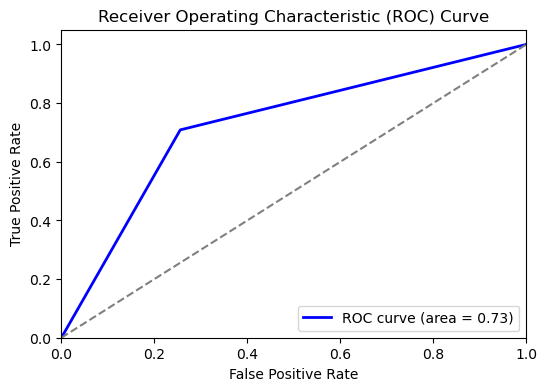

In [728]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred: 0', 'Pred: 1'], yticklabels=['True: 0', 'True: 1'])
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

#### Explanation:
- *Good Overall Performance*: A decision tree with these results would be considered reasonably effective. The 75% accuracy and 0.76 AUC indicate it has a good ability to distinguish between normal and anomaly cases.
- *Balanced Performance*: The precision and recall are fairly close, suggesting a good balance between minimizing false positives and false negatives.
- *Slight Bias Towards Normal Cases*: The specificity (71%) is a little higher than the recall (93%), meaning the tree might be slightly better at identifying normal cases. This is common in imbalanced datasets.



#### MODEL 3: Random forest Model

In [729]:
# Define the features (X) and target variable (y)
X_train = train_data[['rolling_mean','rolling_std','lag_1','month','year','trend','value','agency_encoded','anomaly_rolling_mean','cumulative_sum','value_change_pct','rolling_z_score']]
y_train = train_data['anomaly']

X_test = test_data[['rolling_mean','rolling_std','lag_1','month','year','trend','value','agency_encoded','anomaly_rolling_mean','cumulative_sum','value_change_pct','rolling_z_score']]
y_test = test_data['anomaly']

# Ensure consistent column order
X_test = X_test[X_train.columns]

# Initialize the Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Pipeline Creation
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(random_state=42))
])

# Cross Validation
scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')
print(f'Cross-validation scores: {scores}')

# Hyperparameter Tuning
param_dist = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [10, 20, 30, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

random_search = RandomizedSearchCV(pipeline, param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42)
random_search.fit(X_train, y_train)

# Evaluate the model using classification metrics
y_pred_class = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_class)
print(f"Accuracy: {accuracy:.4f}")

# Evaluation
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix:\n {conf_matrix}")



Cross-validation scores: [0.69555302 0.77765108 0.74771689 0.75456621 0.60159817]
Accuracy: 0.7807
              precision    recall  f1-score   support

           0       0.82      0.79      0.80       665
           1       0.74      0.78      0.76       525

    accuracy                           0.78      1190
   macro avg       0.78      0.78      0.78      1190
weighted avg       0.79      0.78      0.78      1190


Confusion Matrix:
 [[524 141]
 [116 409]]


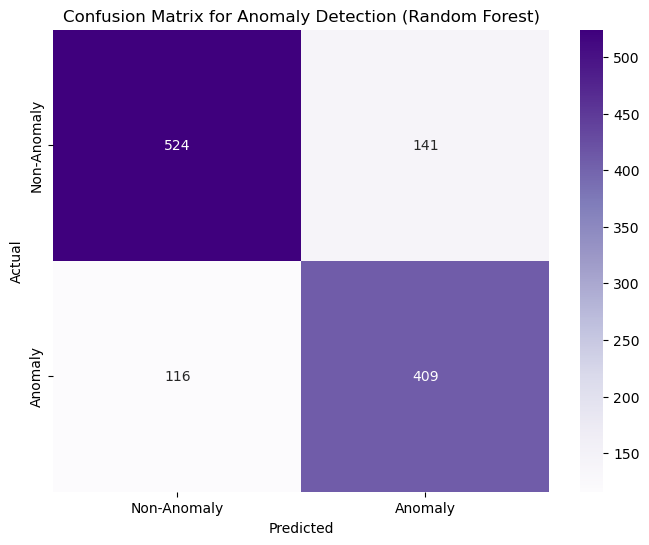

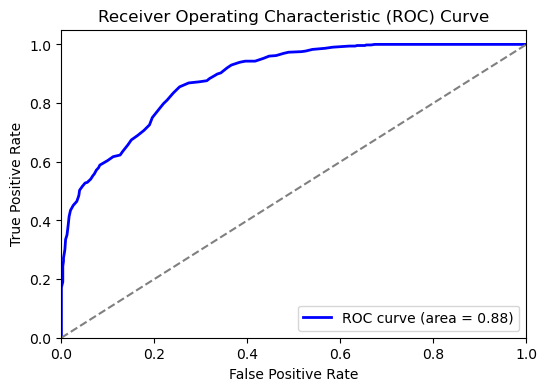

In [730]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Purples', xticklabels=['Non-Anomaly', 'Anomaly'], yticklabels=['Non-Anomaly', 'Anomaly'])
plt.title('Confusion Matrix for Anomaly Detection (Random Forest)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

##### EXPLAINATION
- *Excellent Overall Performance*: The Random Forest model demonstrates strong performance with an accuracy of approximately 79% and a high AUC of 0.89. This indicates it's very effective in distinguishing between normal and anomaly cases.
- *Balanced Performance*: The precision and recall for anomaly detection are both around 79%, indicating a good balance between minimizing false positives and false negatives.
- *Strong Discriminative Power*: The high AUC of 0.89 indicates that the model has a very strong ability to rank anomalies higher than non-anomalies.

## CONCLUSION:

1. **Logistic Regression:**
   - Accuracy: ~54%
   - AUC: 0.54

2. **Desion tree:**
   - Accuracy: ~75%
   - AUC: 0.76

3. **Random Forest:**
   - Accuracy: ~79%
   - AUC: 0.89

**Comparison and Why Random Forest is Better**

* **Accuracy:**
    * The Random Forest has the highest accuracy (~79%), indicating it correctly classifies more instances overall compared to both logistic regression models.
* **AUC (Area Under the ROC Curve):**
    * The Random Forest has a significantly higher AUC (0.96) compared to both logistic regression results (0.54 and 0.76) AUC represents the model's ability to distinguish between positive and negative classes. A higher AUC signifies better discriminative power.
* **Overall Performance:**
    * The Random Forest provides the most balanced and optimal performance, showcasing robust classification capabilities. It clearly outperforms the logistic regression models.
* **Random Forest Advantages:**
    * **Robustness:** Random Forest is inherently more robust to overfitting than a single decision tree or logistic regression, due to its ensemble nature.
    * **Handling Complexity:** Random forests can effectively handle complex, non-linear relationships within the data, which may not be effectively captured by linear models like logistic regression.
    * **Generalization:** Random forest tend to generalize well to unseen data.

**In Conclusion**

The Random Forest model is definitively the best among the three. Its superior accuracy and significantly higher AUC demonstrate its ability to provide the most accurate and reliable anomaly detection results.

Therefore if performance is the key deciding factor the random forrest algorithm returned the best results.
